In [1]:
import os
import torch
from torchvision import datasets, transforms
from utils import loaders_by_classes, filter_loaders
from classNet import ConvNet # for torch load
from target import fast_normalization_method

In [2]:
model = torch.load('./models/all_class.pth', weights_only=False)
model.eval()
model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
num_workers = os.cpu_count()
test_loaders = loaders_by_classes(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# Choose class to Test

In [84]:
class_name = '0 - zero'
class_loader = test_loaders[class_name]

{'0 - zero': <torch.utils.data.dataloader.DataLoader at 0x328b307d0>,
 '1 - one': <torch.utils.data.dataloader.DataLoader at 0x32893ce00>,
 '2 - two': <torch.utils.data.dataloader.DataLoader at 0x328b451f0>,
 '3 - three': <torch.utils.data.dataloader.DataLoader at 0x328b59b80>,
 '4 - four': <torch.utils.data.dataloader.DataLoader at 0x328b82f90>,
 '5 - five': <torch.utils.data.dataloader.DataLoader at 0x328ba0740>,
 '6 - six': <torch.utils.data.dataloader.DataLoader at 0x328ba0470>,
 '7 - seven': <torch.utils.data.dataloader.DataLoader at 0x328ba0230>,
 '8 - eight': <torch.utils.data.dataloader.DataLoader at 0x328ba08c0>,
 '9 - nine': <torch.utils.data.dataloader.DataLoader at 0x328ba0980>}

# Gradients pour classic Loss 

In [85]:
# Calcul des gradients pour Loss_1

# On filtre pour sample tout sauf la classe choisie
filtered_loader = filter_loaders(test_loaders, class_name, batch_size, shuffle=True, num_workers=num_workers)

In [86]:
input, label = next(iter(filtered_loader))

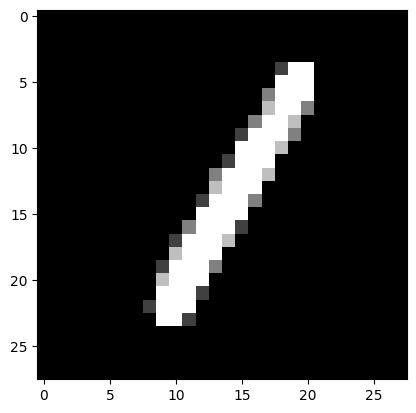

In [87]:
# plot un example d'image input
import matplotlib.pyplot as plt
plt.imshow(input[0].squeeze(), cmap='gray')

In [88]:
def get_pre_layer_grad(model, layer, input, target, criterion):
    """
    Returns the gradient of the criterion with respect to the input of a specified layer.
    
    Args:
        model (torch.nn.Module): The neural network model.
        layer (torch.nn.Module): The layer at which to get the gradient (e.g., the last layer).
        input (torch.Tensor): The input data for the model.
        target (torch.Tensor): The true target for the input data.
        criterion (callable): The loss function (e.g., torch.nn.CrossEntropyLoss).

    Returns:
        torch.Tensor: The gradient of the loss with respect to the input of the specified layer.
    """
    layer_input_grad = None

    # Hook to capture the gradient of the input at the specified layer
    def backward_hook(module, grad_input, grad_output):
        nonlocal layer_input_grad
        layer_input_grad = grad_input[0]  # The gradient w.r.t. the input activations (128 dimensions)
        
    # Register the backward hook on the layer
    hook = layer.register_full_backward_hook(backward_hook)

    # Perform a forward pass and calculate the loss
    output = model(input)
    loss = criterion(output, target)

    # Perform a backward pass to calculate gradients
    model.zero_grad()
    loss.backward()

    # Remove the hook
    hook.remove()

    if layer_input_grad is None:
        raise RuntimeError("Layer input gradient is None; ensure the layer has `requires_grad=True`.")

    # Return the gradient of the layer's input (batch x layer dimensions)
    return layer_input_grad.detach()

In [89]:
input, label = input.to(device), label.to(device)
_, last_layer = list(model.named_children())[-1]
grad_1 = get_pre_layer_grad(model, last_layer, input, label, torch.nn.CrossEntropyLoss())
grad_1.size()

torch.Size([64, 128])

# Gradient pour Target Loss

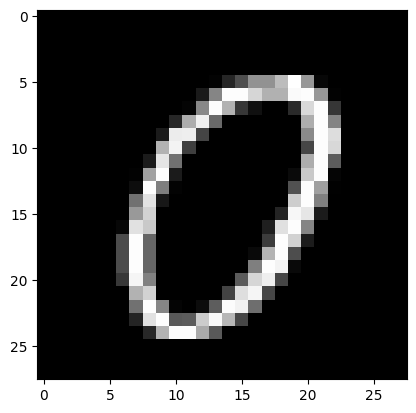

In [113]:
input, _ = next(iter(class_loader))
# plot un example d'image input
import matplotlib.pyplot as plt
plt.imshow(input[0].squeeze(), cmap='gray')
input = input.to(device)

In [96]:
def get_output_target(output, class_num):
    output_excluded = torch.cat([output[:, :class_num], output[:, class_num+1:]], dim=1)
    _output_excluded = output_excluded.detach()
    target = _output_excluded - torch.mean(_output_excluded, dim=1, keepdim=True)
    return output_excluded, target

def get_intermediate_grad(model, input_tensor):
    """
    Capture le gradient par rapport aux activations d'entrée du dernier layer paramétrique.

    Args:
        model (torch.nn.Module): Le modèle de réseau de neurones.
        input_tensor (torch.Tensor): Les données d'entrée pour le modèle.

    Returns:
        torch.Tensor: Gradient de la perte par rapport aux activations d'entrée du dernier layer paramétrique.
    """
    # Trouver le dernier layer paramétrique
    layers_with_params = [layer for layer in model.children() if hasattr(layer, 'weight') or hasattr(layer, 'bias')]
    if not layers_with_params:
        raise RuntimeError("Aucun layer paramétrique trouvé dans le modèle.")

    last_param_layer = layers_with_params[-1]
    last_input = None

    # Hook pour capturer les activations d'entrée du dernier layer paramétrique
    def capture_input(module, inp, output):
        nonlocal last_input
        last_input = inp[0]
        last_input.retain_grad()  # Assure que le gradient est retenu pour un tensor non-feuille

    hook = last_param_layer.register_forward_hook(capture_input)

    # Calcul de la sortie
    output = model(input_tensor)
    output_excluded, target = get_output_target(output, class_num=0)

    # Calcul de la perte et rétropropagation
    loss = torch.nn.functional.mse_loss(output_excluded, target)
    model.zero_grad()
    loss.backward()

    # Retirer le hook
    hook.remove()

    # Vérification et récupération du gradient de l'entrée du dernier layer paramétrique
    if last_input.grad is None:
        raise RuntimeError("Le gradient n'a pas été calculé pour l'entrée du dernier layer.")

    return last_input.grad  # Retourne le gradient

# Exécution exemple si 'model' et 'input_tensor' sont définis
try:
    grad_2 = get_intermediate_grad(model, input)
    print("Gradient size:", grad.size())
except RuntimeError as e:
    print(e)

Gradient size: torch.Size([64, 128])


# Calcul Masking

In [105]:
mg1 = torch.mean(grad_1, dim=0, keepdim=True)
mg2 = torch.mean(grad_2, dim=0, keepdim=True)

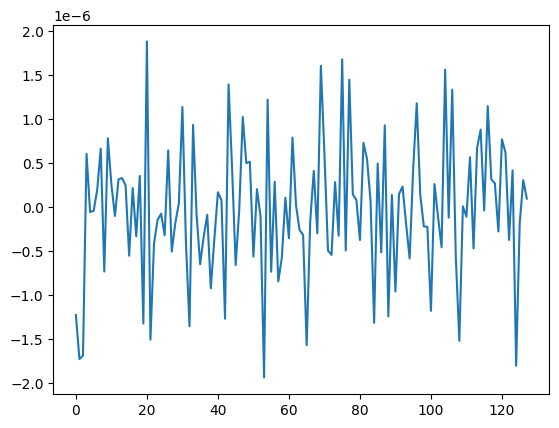

In [106]:
plt.plot(mg1[0].detach().cpu().numpy())

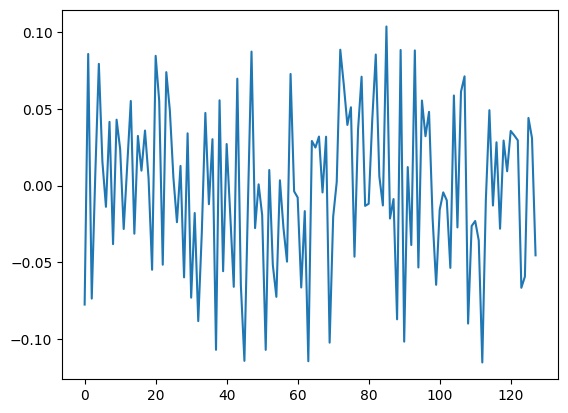

In [107]:
plt.plot(mg2[0].detach().cpu().numpy())

In [108]:
mask = mg1 * mg2 > 0

In [111]:
model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [110]:
list(model.parameters())

[Parameter containing:
 tensor([[[[-1.1821e-01,  2.3094e-01,  4.4265e-01],
           [-2.3558e-01, -1.0026e-01,  3.4404e-01],
           [-3.2443e-02,  2.1631e-01,  8.7450e-02]]],
 
 
         [[[-1.9941e-01, -4.1640e-02,  4.3671e-01],
           [ 3.9129e-01, -3.5305e-02, -2.3355e-01],
           [-1.1652e-01, -1.2156e-01, -1.4418e-01]]],
 
 
         [[[ 1.0977e-01,  1.5989e-01, -1.3099e-01],
           [ 4.3489e-01, -2.4218e-01, -4.3694e-01],
           [-2.1994e-01, -7.1986e-01,  3.4685e-01]]],
 
 
         [[[-2.7038e-01, -1.3107e-01,  5.8529e-02],
           [ 3.8142e-01,  1.1355e-02, -9.0815e-02],
           [ 1.1384e-02,  3.3062e-01,  1.7527e-01]]],
 
 
         [[[ 1.5485e-01, -3.2326e-01, -1.1294e-01],
           [-2.4733e-01, -2.6055e-01, -1.2035e-01],
           [-9.1667e-02, -8.0525e-02, -2.5608e-01]]],
 
 
         [[[ 3.0610e-01, -4.4332e-03,  1.1065e-01],
           [-1.3182e-01,  1.8354e-01,  1.1627e-02],
           [ 1.4040e-01, -9.7281e-05,  3.6290e-02]]],
 
 
     

In [115]:
input_tensor = input

In [121]:
import torch

def get_param_grad(model, input_tensor):
    """
    Capture le gradient de la perte par rapport aux paramètres (poids et biais) du dernier layer paramétrique.

    Args:
        model (torch.nn.Module): Le modèle de réseau de neurones.
        input_tensor (torch.Tensor): Les données d'entrée pour le modèle.

    Returns:
        torch.Tensor: Gradient de la perte par rapport aux poids et biais du dernier layer paramétrique.
    """
    # Assurez-vous que l'entrée a bien requires_grad activé
    input_tensor.requires_grad_(True)

    # Passer en avant jusqu'au dernier layer paramétrique
    output = model(input_tensor)

    # Création de la cible
    output_excluded, target = get_output_target(output, class_num=0)

    # Calcul de la perte et rétropropagation
    loss = torch.nn.functional.mse_loss(output_excluded, target)
    loss.backward()

    # Récupérer le gradient des poids et biais du dernier layer paramétrique
    last_layer = list(model.children())[-1]  # Dernier layer du modèle

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in last_layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    # Concaténer tous les gradients (poids et biais) pour obtenir une seule dimension
    all_gradients = torch.cat(grad_params, dim=0)  # Contient tous les gradients

    # Calcul du nombre total de paramètres dans le dernier layer paramétrique
    total_params = sum(p.numel() for p in last_layer.parameters())  # Total des paramètres (poids + biais)

    # Assurez-vous que la taille est correcte pour une sortie de taille (batch_size, total_params)
    print(all_gradients.numel(), total_params)

    if all_gradients.numel() != total_params:
        raise RuntimeError(f"Erreur de taille : taille de all_gradients ({all_gradients.numel()}) ne correspond pas à "
                             f"total_params ({total_params})")

    # Retourner le gradient sous la forme (batch_size, total_params)
    return all_gradients

# Exécution exemple si 'model' et 'input_tensor' sont définis
try:
    grad = get_param_grad(model, input_tensor)
    print("Gradient size:", grad.size())  # Devrait donner (batch_size, nombre_de_paramètres)
except RuntimeError as e:
    print(e)


1290 1290
Gradient size: torch.Size([1290])


In [124]:
grad.size()

torch.Size([1290])

In [ ]:
mask
optimizer = optim.Adam(model.parameters(), lr=0.001)

tensor([[ True, False,  True,  True, False, False, False,  True,  True,  True,
          True,  True,  True,  True, False, False,  True, False,  True,  True,
          True, False,  True, False, False, False, False, False,  True,  True,
         False,  True,  True, False, False,  True, False,  True, False,  True,
          True, False,  True,  True, False,  True,  True,  True, False,  True,
          True, False, False,  True, False, False, False,  True, False, False,
          True, False, False,  True, False, False, False, False, False, False,
         False, False, False,  True, False,  True,  True,  True,  True, False,
          True,  True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True, False, False,  True,  True,  True,  True,  True,  True,
          True, False,  True,  True,  True,  True,  True, False,  True, False,
          True, False,  True, False,  True,  True,  True, False,  True, False,
          True,  True, False, False,  True, False,  